# Crimes summed up by Type
#### This is the Jupyter Notebook for analyzing the relationship between different kinds of crimes and community areas' different socioeconomic status. To be clear, No_Crimes is the number of crimes happended on average in one year during the 2008 - 2012 time period.

First we import data from the City of Chicago Data Portal's API.
The exported csv file from the website is over 1.5 GB and hard to work with.

In [4]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS No_Crimes, primary_type AS Primary_Type ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community, Primary_Type LIMIT 10000")

resp = requests.get(soql).json()

crime_type = pd.DataFrame(resp)
crime_type.No_Crimes = crime_type.No_Crimes.astype(float)
crime_type.round(1) 

crime_type.dropna(axis = 0, how = "any", inplace = True) 
socioeconomics = pd.read_csv("./../data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv")
# rename "community"
crime_type.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_type['Community Area Number'] = crime_type['Community Area Number'].astype(float)

mix_type = pd.DataFrame.merge(crime_type, socioeconomics, on = 'Community Area Number')
mix_type.head()

,Community Area Number,No_Crimes,Primary_Type,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,4.6,ARSON,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,1.0,344.8,ASSAULT,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2,1.0,1038.6,BATTERY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
3,1.0,279.6,BURGLARY,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
4,1.0,630.6,CRIMINAL DAMAGE,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0


In [5]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz

from urllib.parse import quote

import scipy
from scipy import stats
from scipy import special
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/bac2qh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Once again we perform logit-transformation on our dataset

In [6]:
# create a logit-processed dataframe
mix_type_logit = mix_type.copy()
mix_type_logit['PERCENT OF HOUSING CROWDED'] = scipy.special.logit(mix_type_logit['PERCENT OF HOUSING CROWDED']/100)
mix_type_logit['PERCENT HOUSEHOLDS BELOW POVERTY'] = scipy.special.logit(mix_type_logit['PERCENT HOUSEHOLDS BELOW POVERTY']/100)
mix_type_logit['PERCENT AGED 16+ UNEMPLOYED'] = scipy.special.logit(mix_type_logit['PERCENT AGED 16+ UNEMPLOYED']/100)
mix_type_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA'] = scipy.special.logit(mix_type_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA']/100)
mix_type_logit['PERCENT AGED UNDER 18 OR OVER 64'] = scipy.special.logit(mix_type_logit['PERCENT AGED UNDER 18 OR OVER 64']/100)

Check the dataset

In [7]:
# Types of crimes recorded
mix_type_logit.Primary_Type.unique()

array(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL DAMAGE',
       'CRIMINAL TRESPASS', 'CRIM SEXUAL ASSAULT', 'DECEPTIVE PRACTICE',
       'GAMBLING', 'HOMICIDE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION',
       'MOTOR VEHICLE THEFT', 'NARCOTICS', 'OBSCENITY',
       'OFFENSE INVOLVING CHILDREN', 'OTHER OFFENSE', 'PROSTITUTION',
       'PUBLIC INDECENCY', 'PUBLIC PEACE VIOLATION', 'ROBBERY',
       'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON-CRIMINAL'], dtype=object)

In [8]:
# Types of socioeconomic status available 
mix_type_logit.columns

Index(['Community Area Number', 'No_Crimes', 'Primary_Type',
       'COMMUNITY AREA NAME', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX'],
      dtype='object')

#### We are intersted in generally the following crimes and socioeconomic status indicators

In [9]:
socio_list = ['PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX']

In [10]:
crimes_list = ['HOMICIDE', 'WEAPONS VIOLATION', 'THEFT', 'KIDNAPPING', 'NARCOTICS', 'ROBBERY', 'SEX OFFENSE']

This is a 7*7 relationship. So a for loop is used to exhaust all the possible regressional plots

/home/bac2qh/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


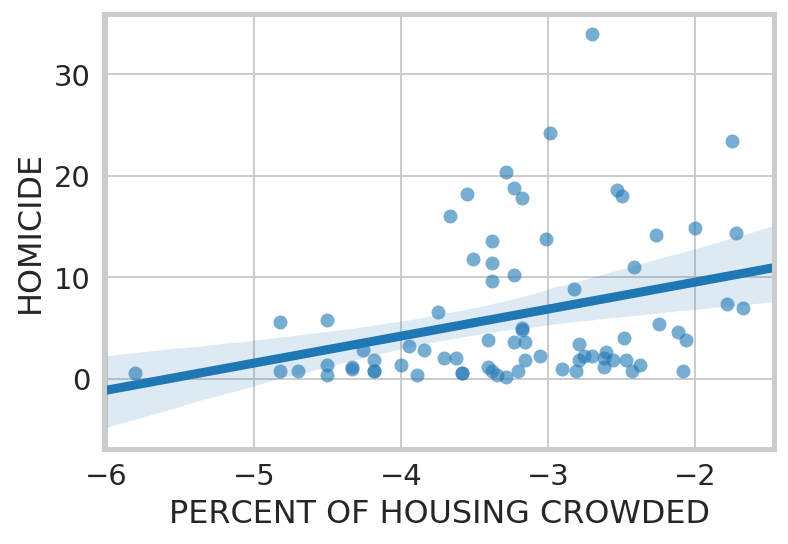

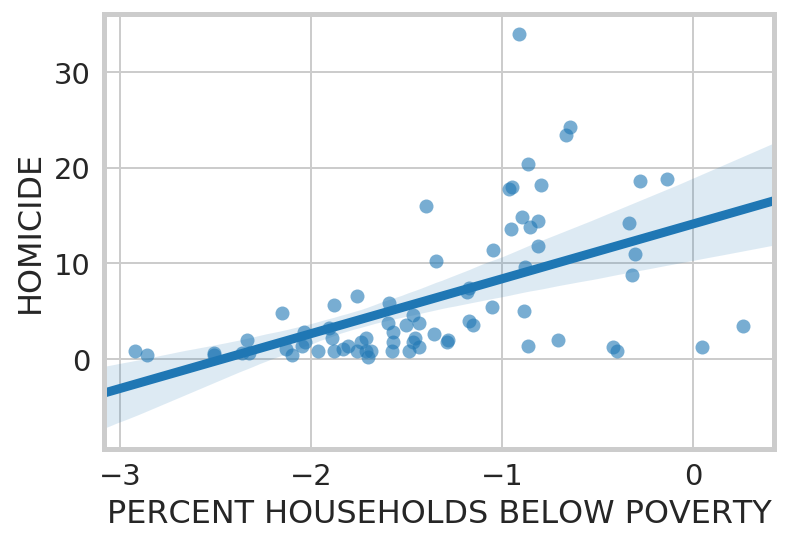

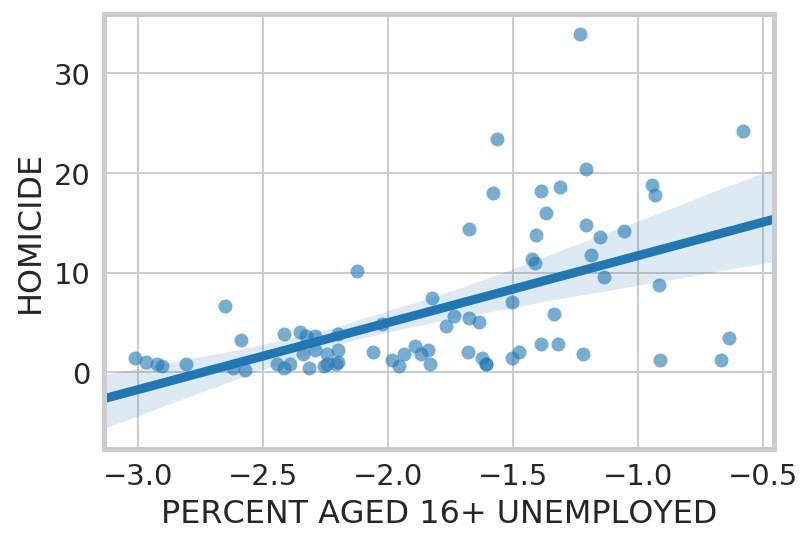

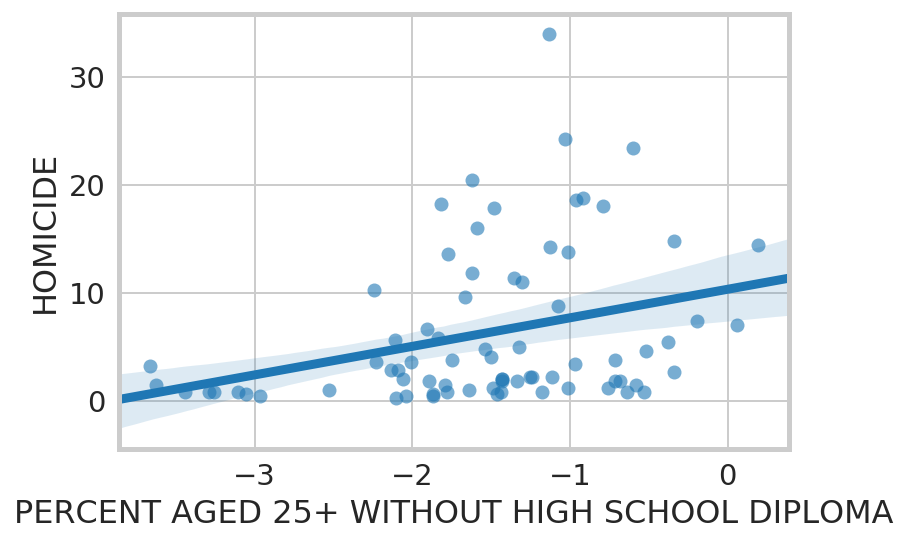

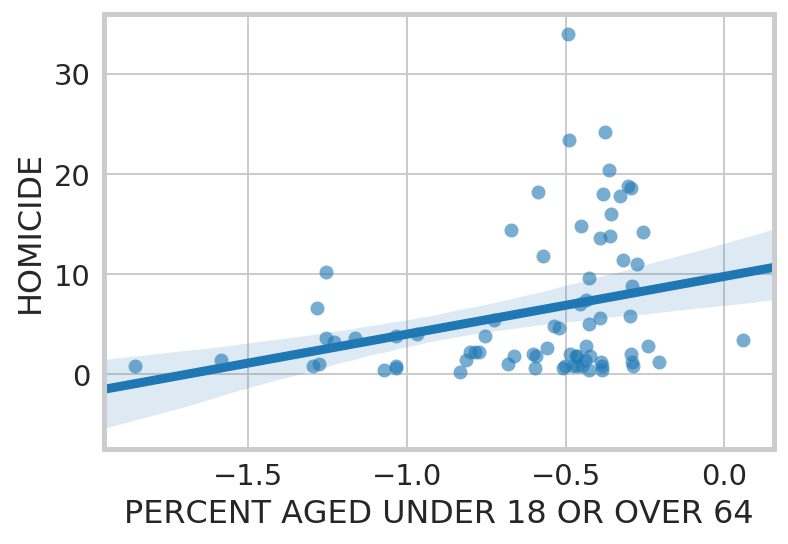

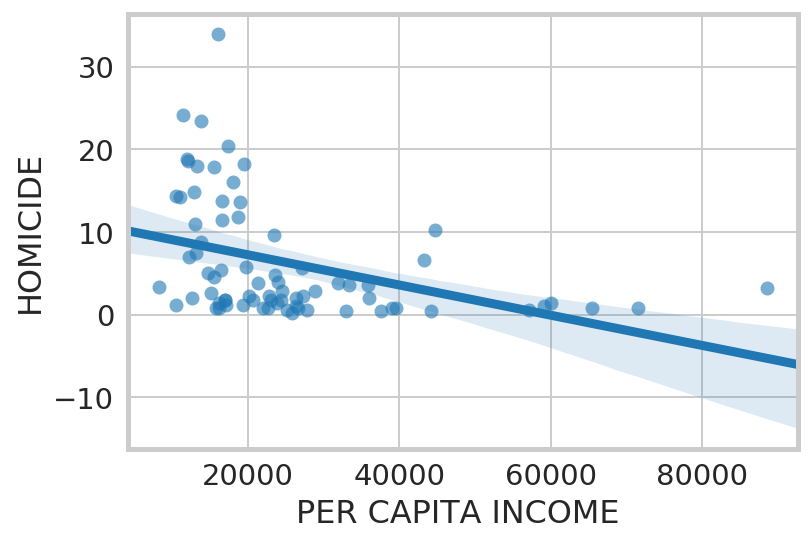

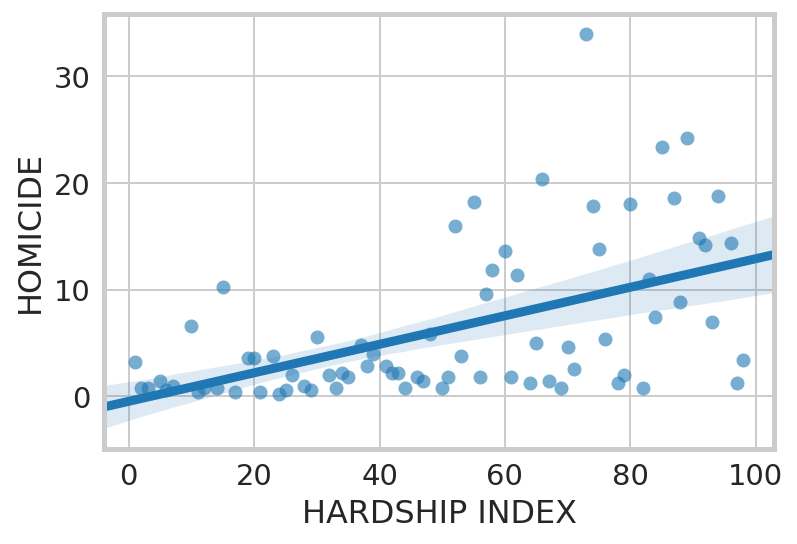

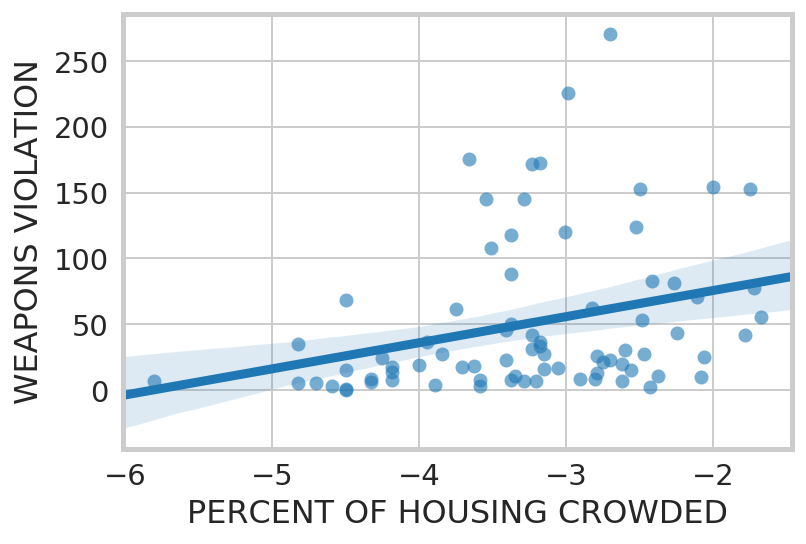

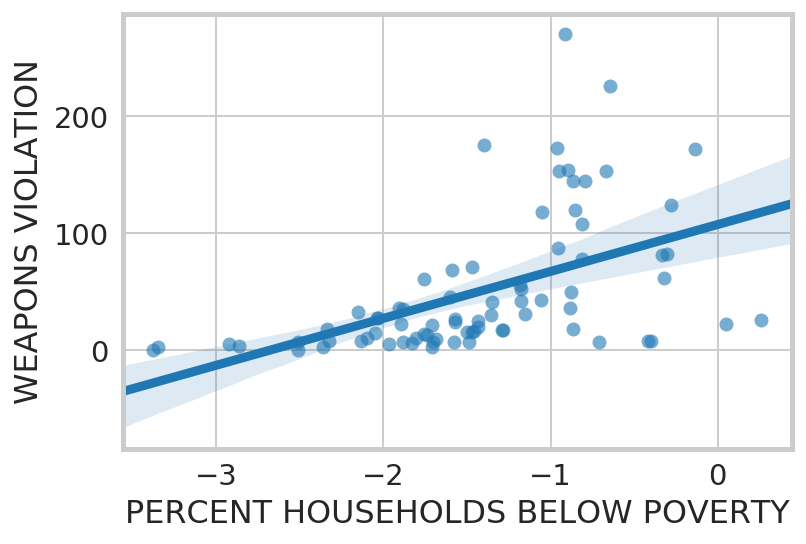

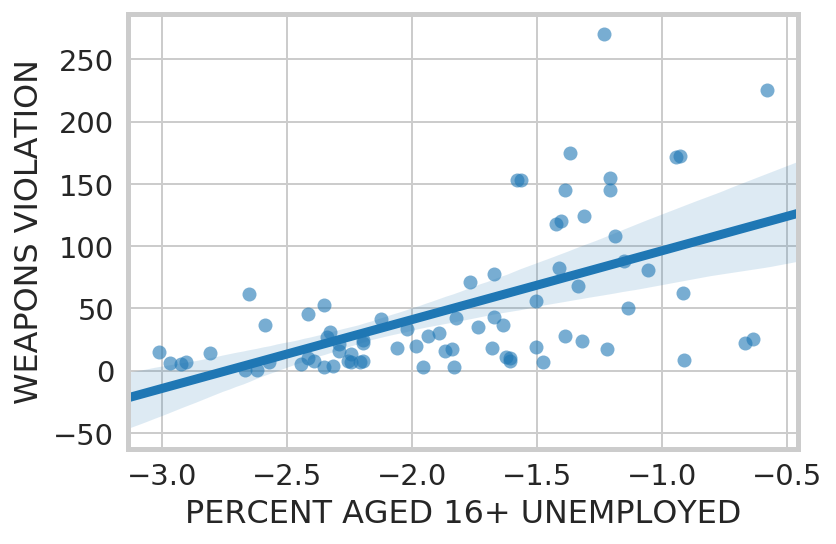

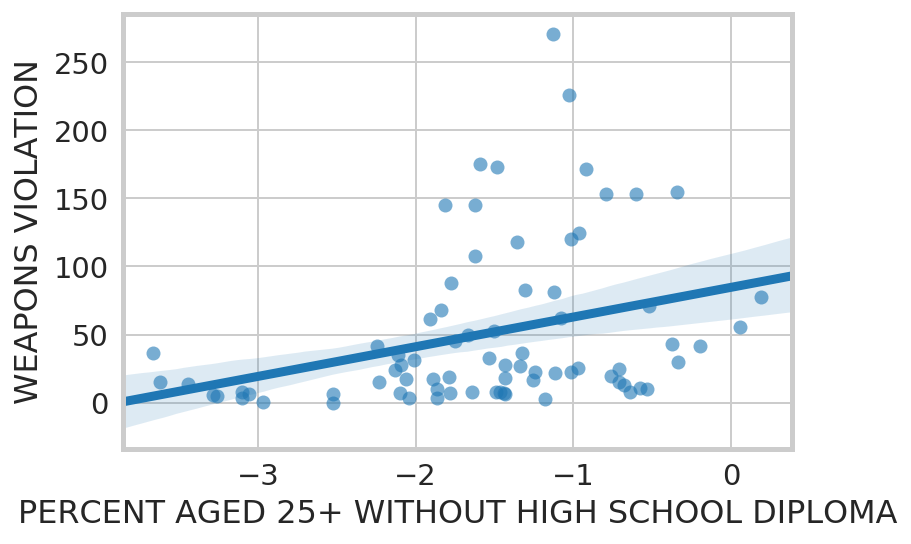

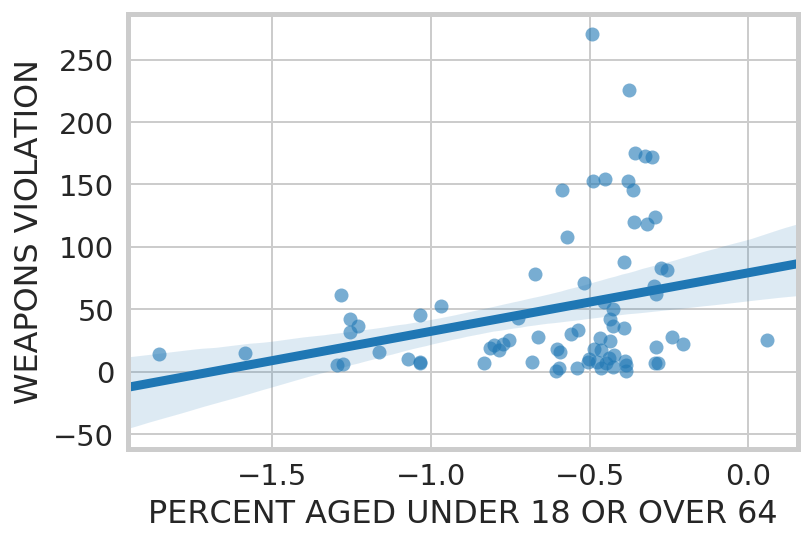

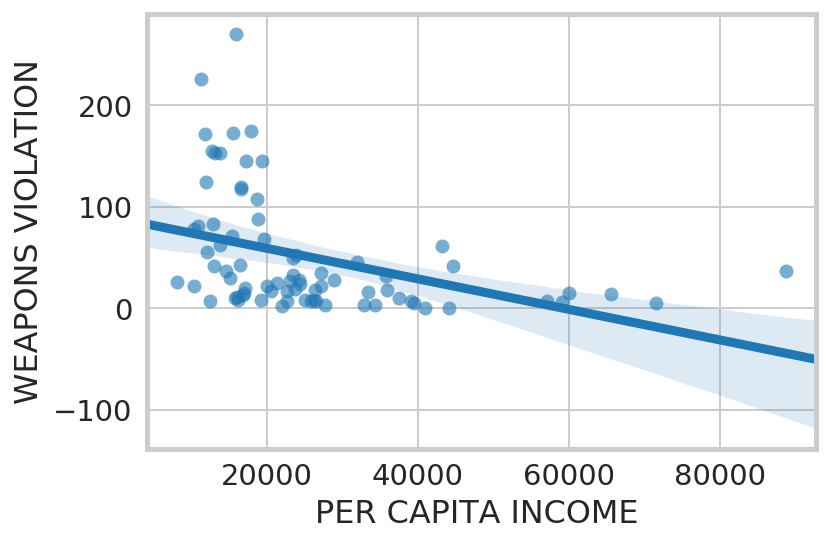

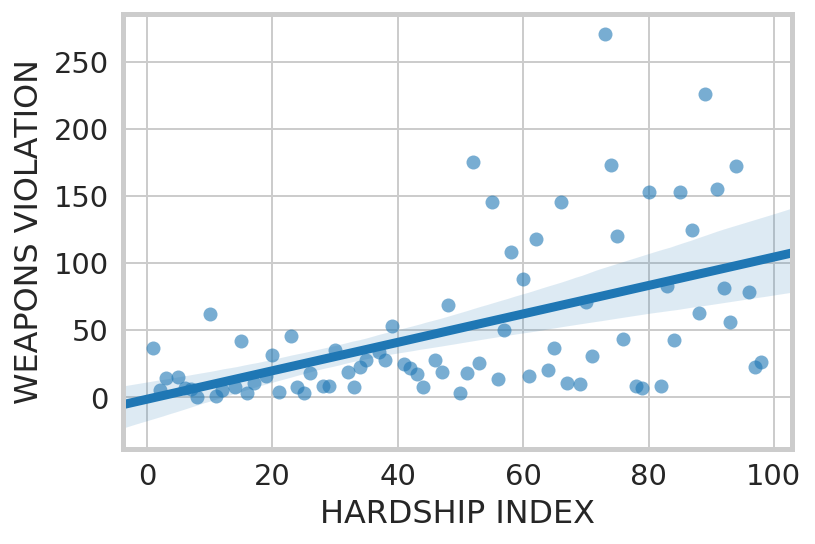

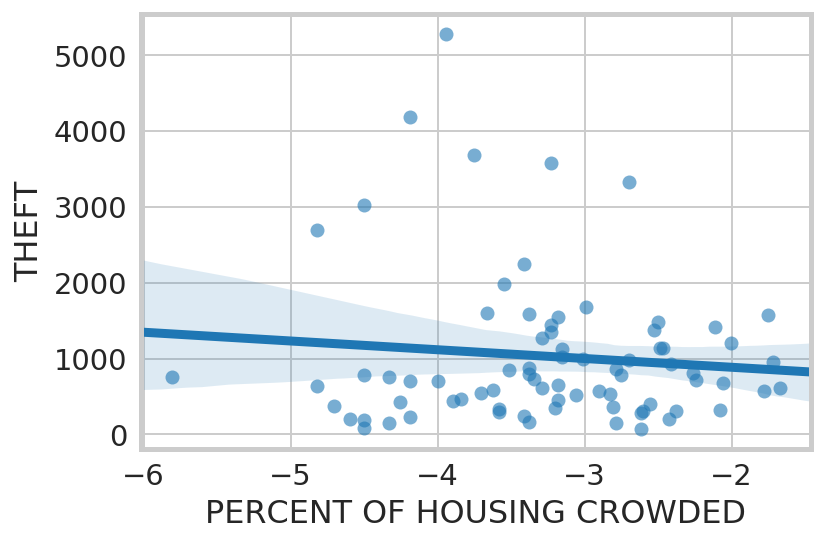

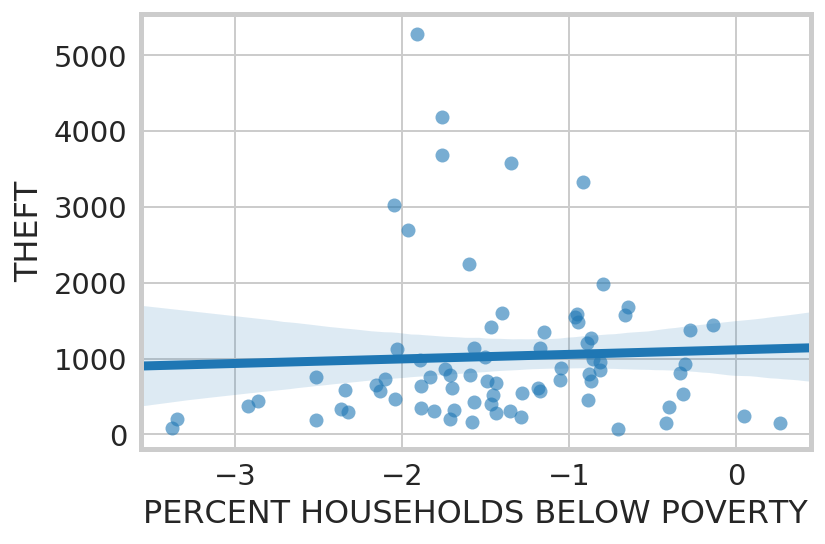

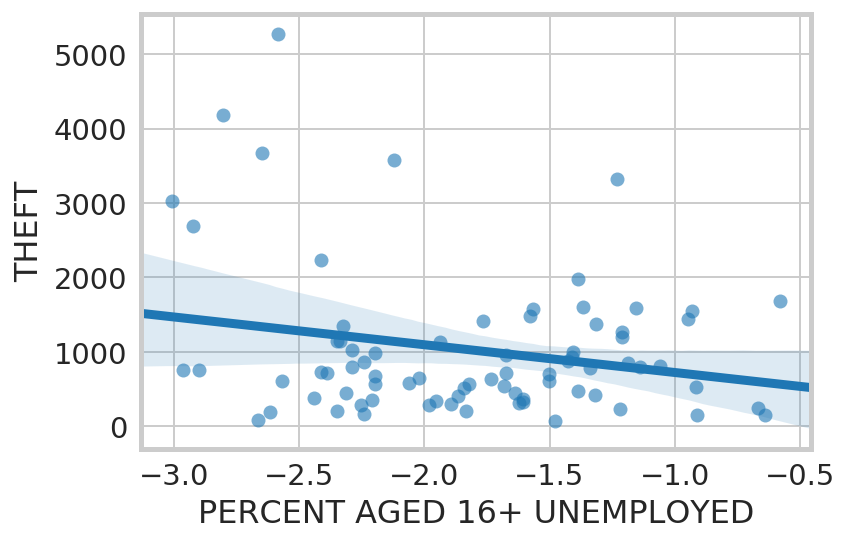

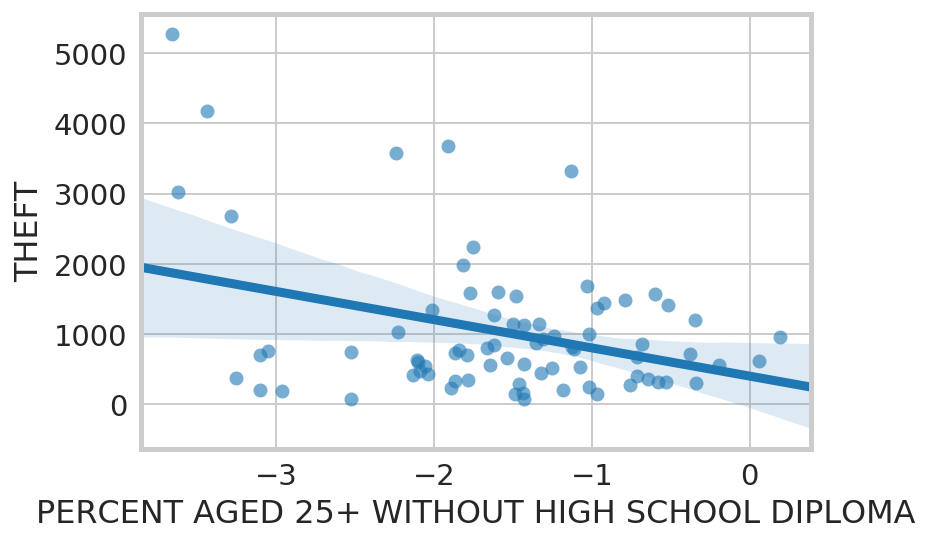

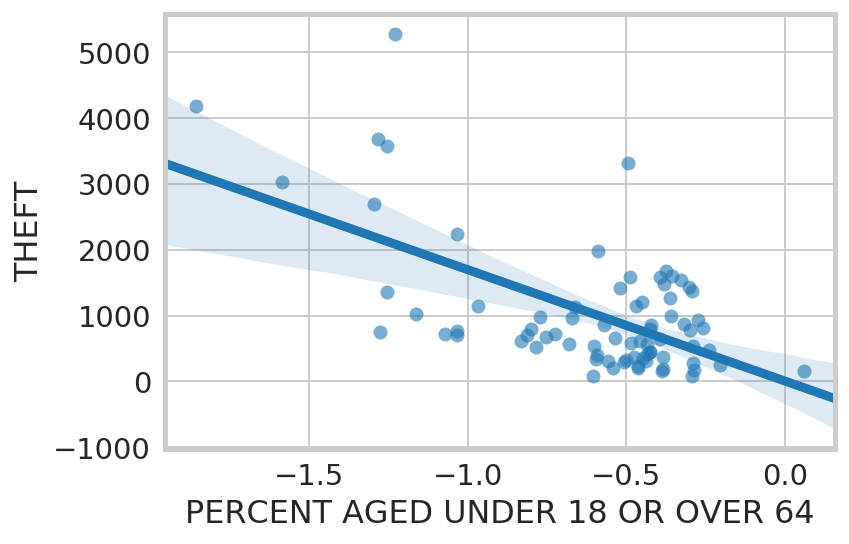

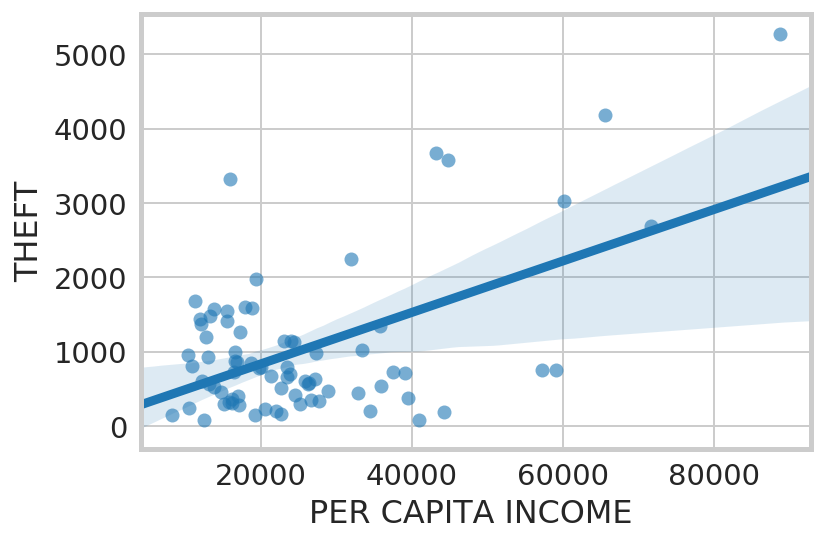

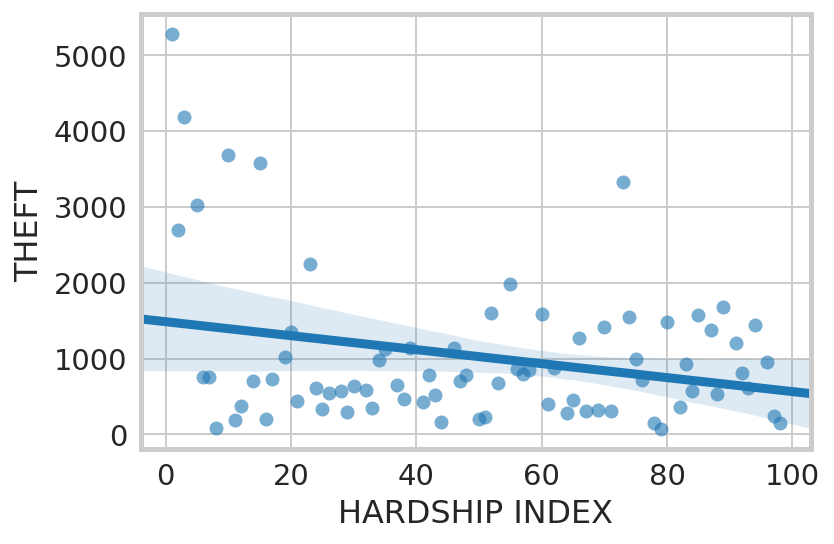

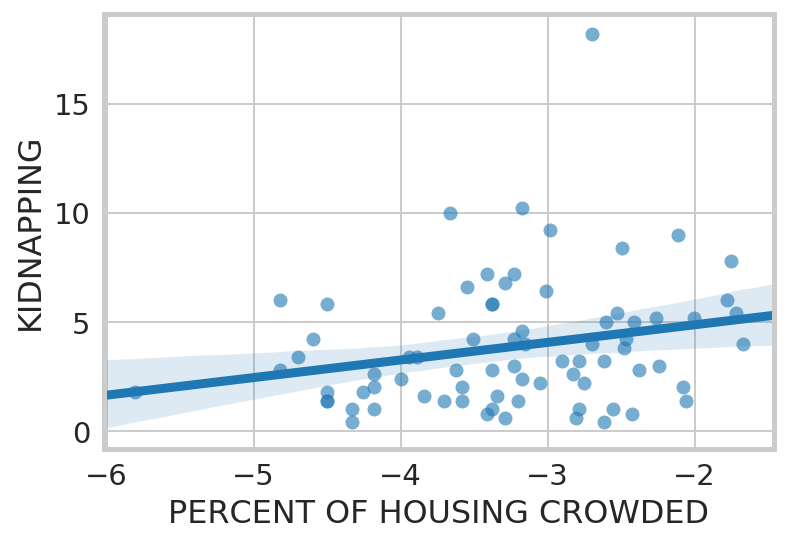

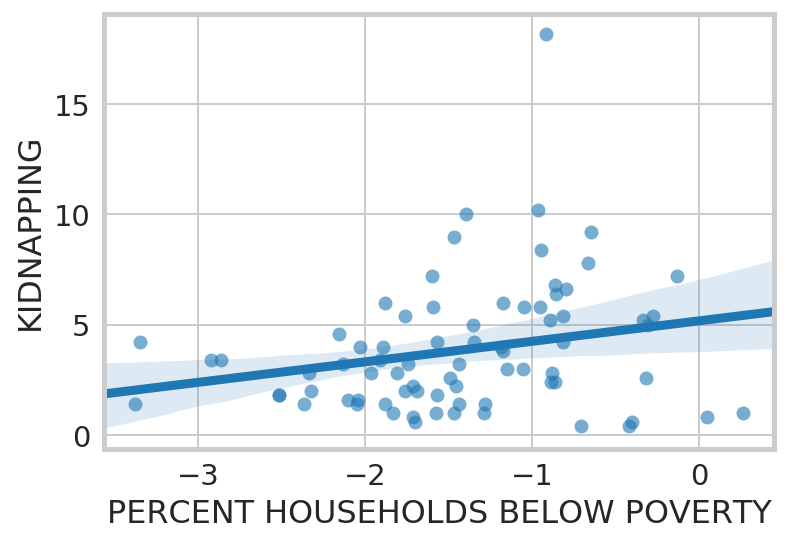

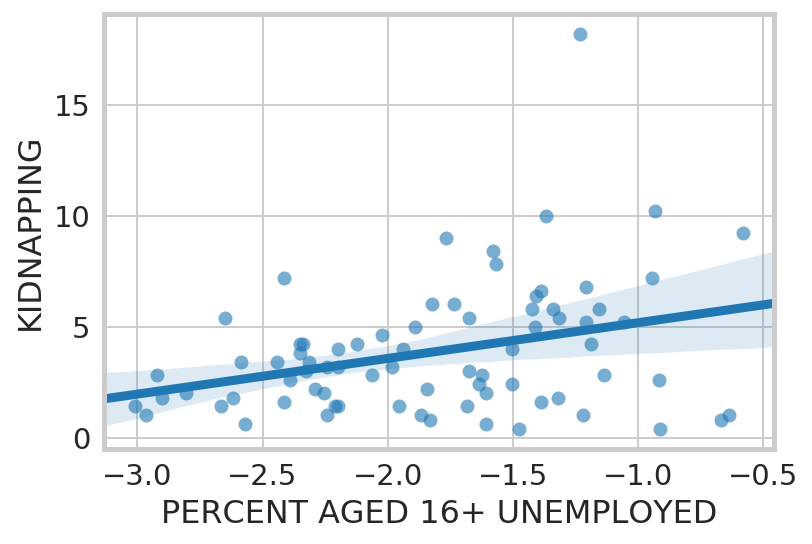

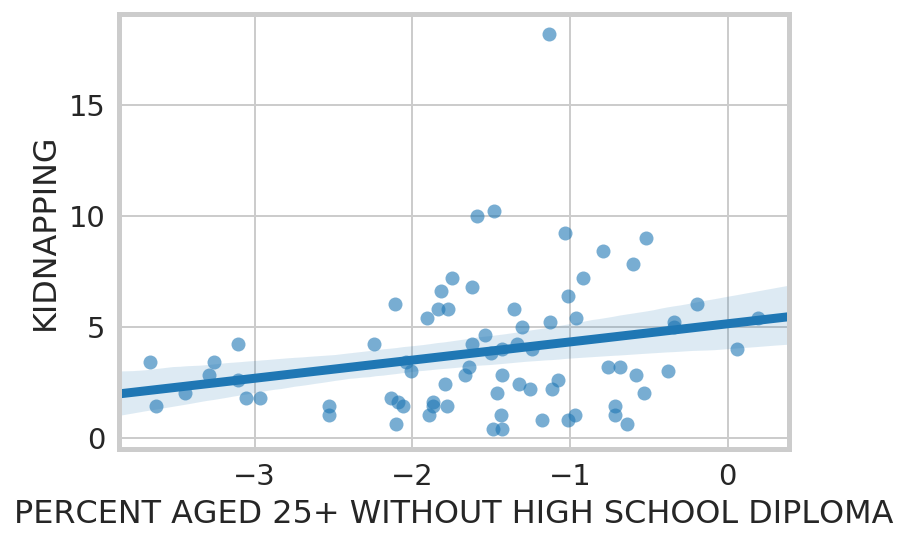

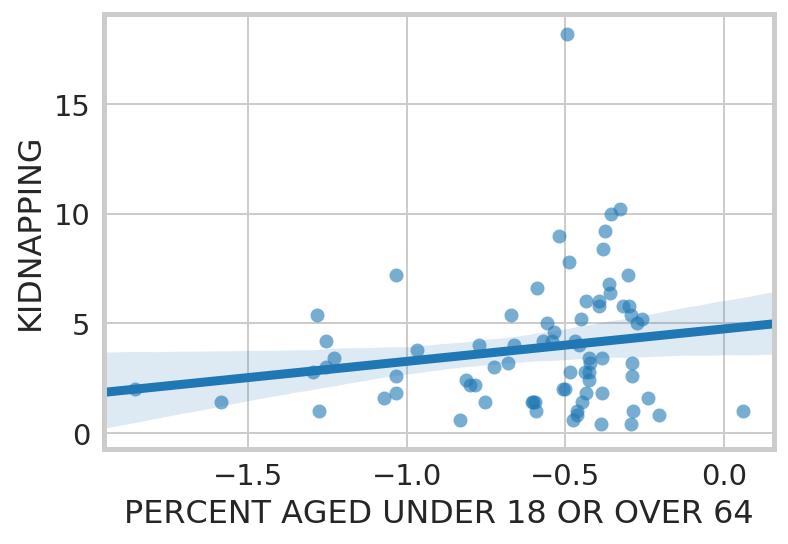

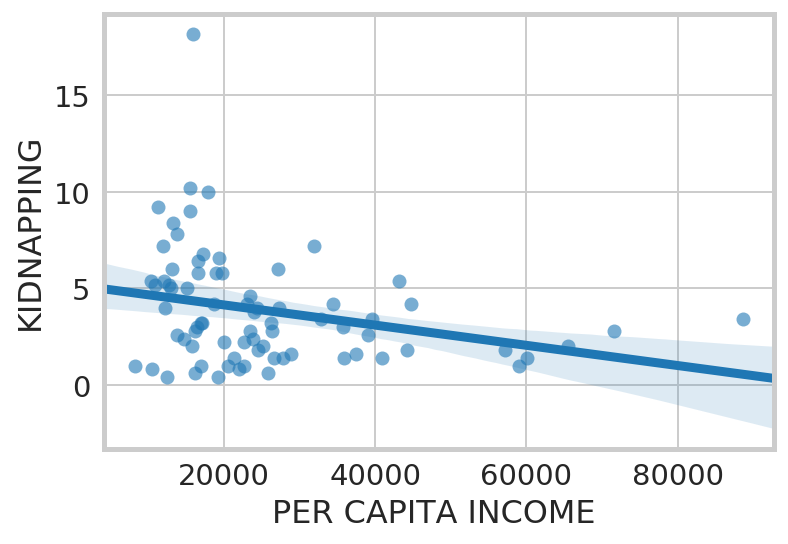

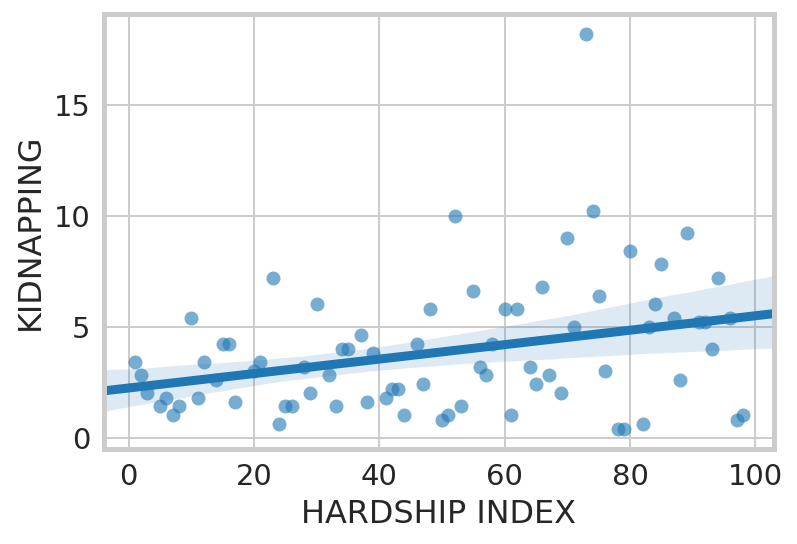

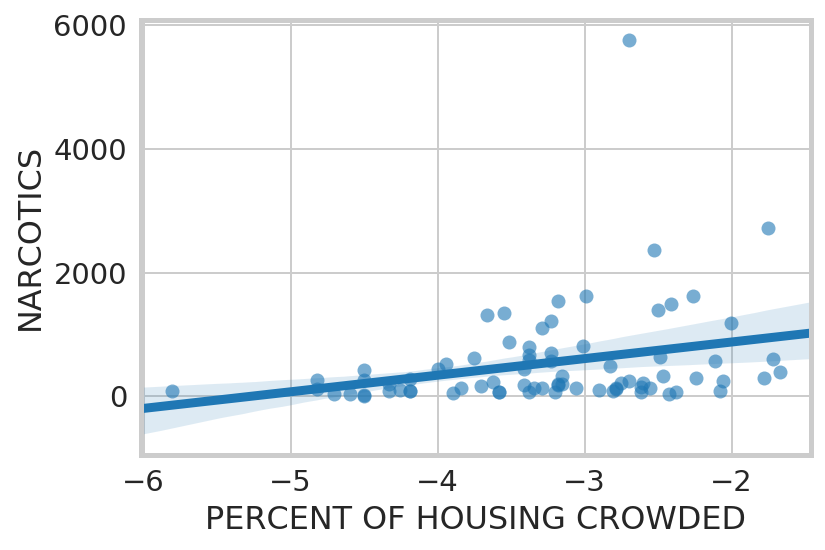

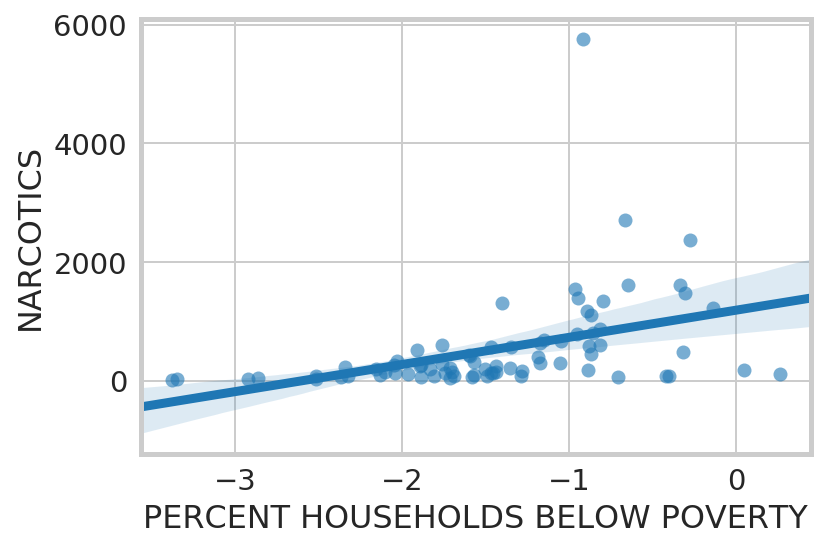

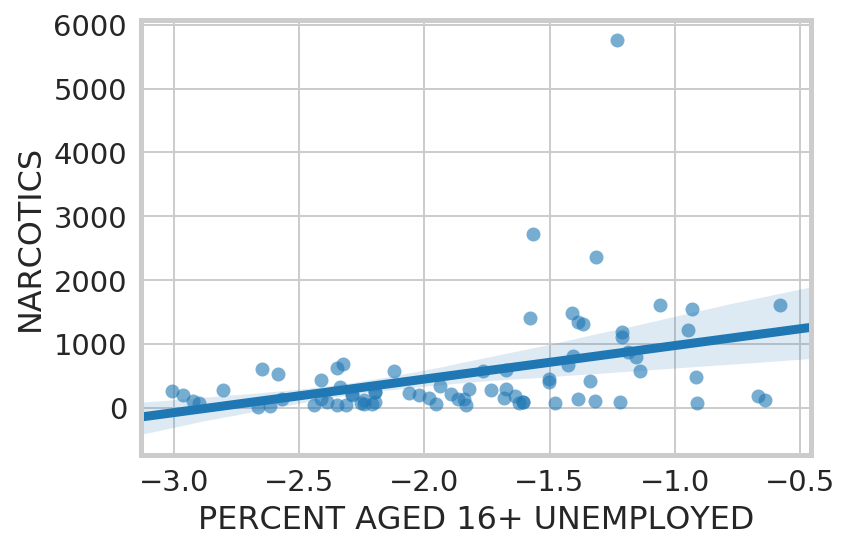

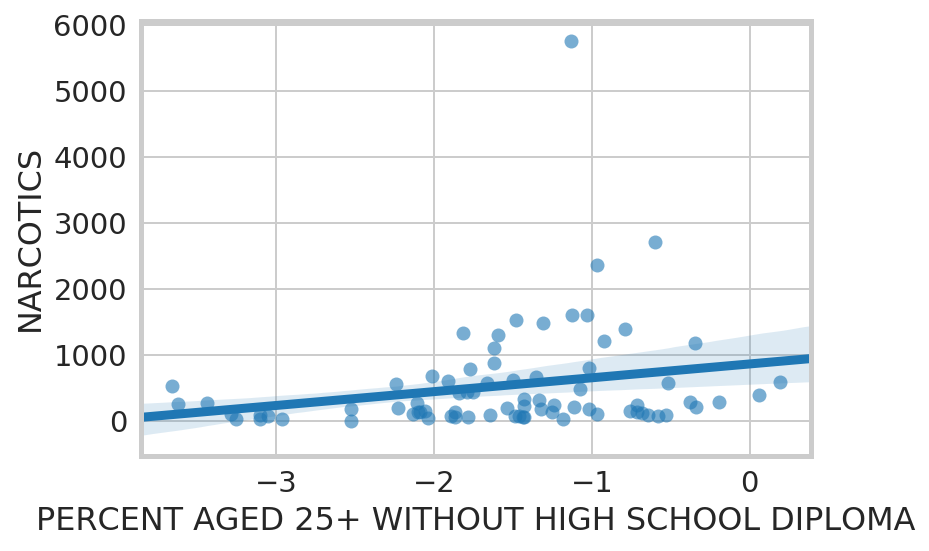

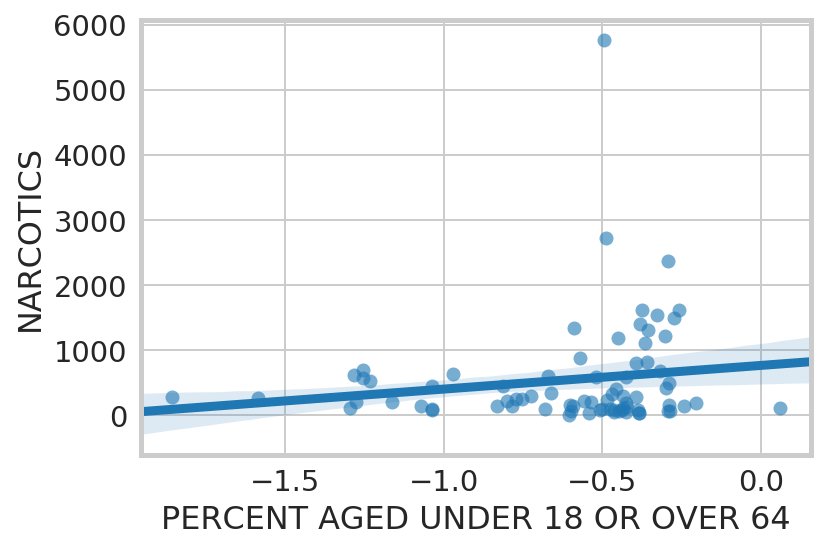

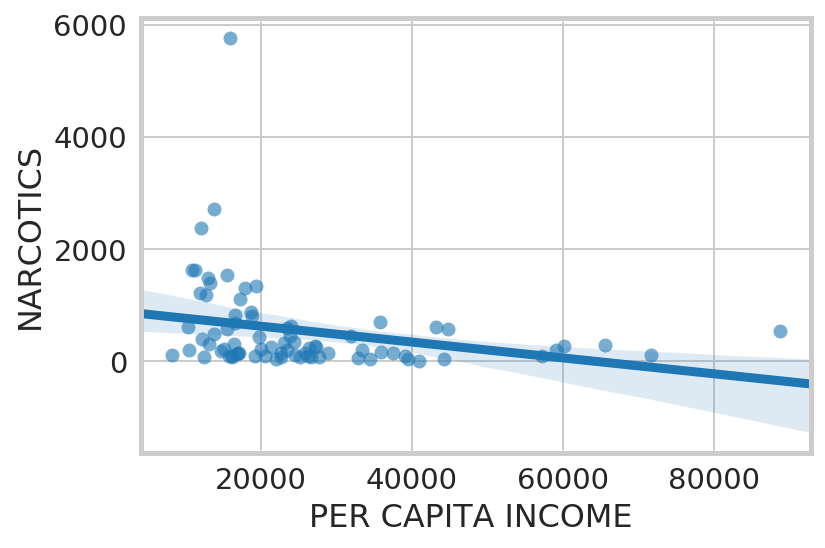

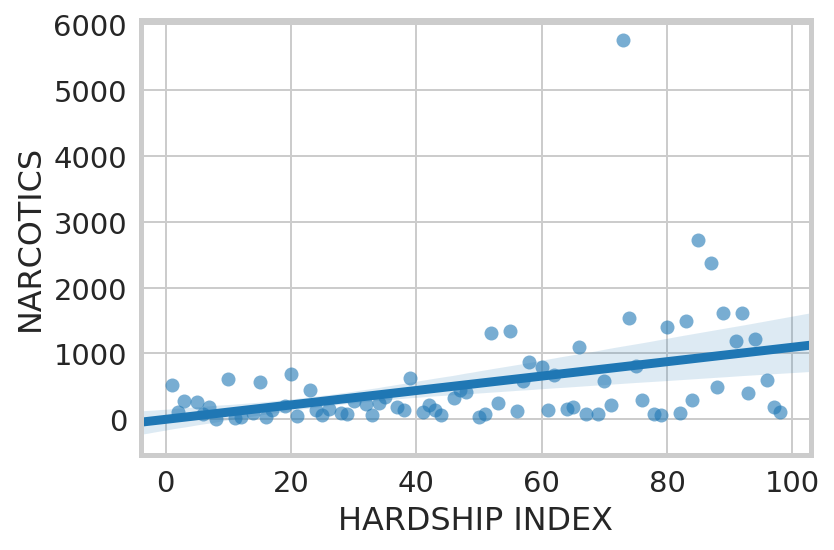

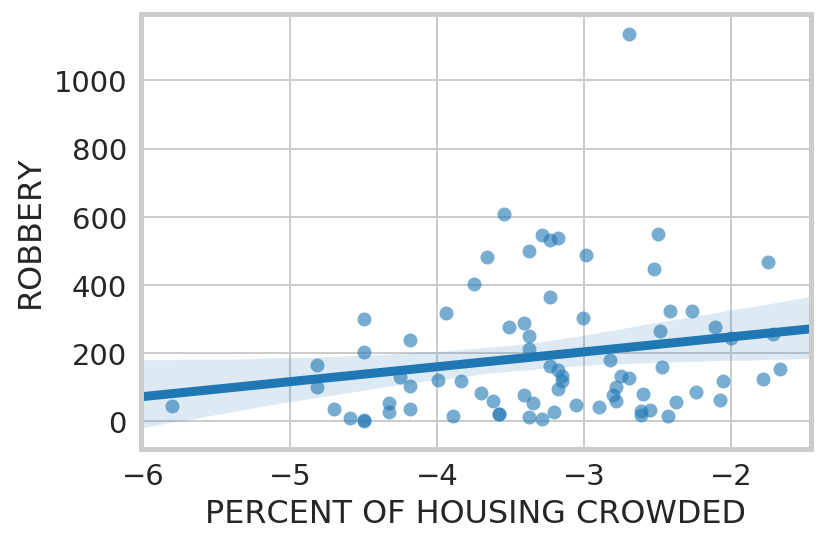

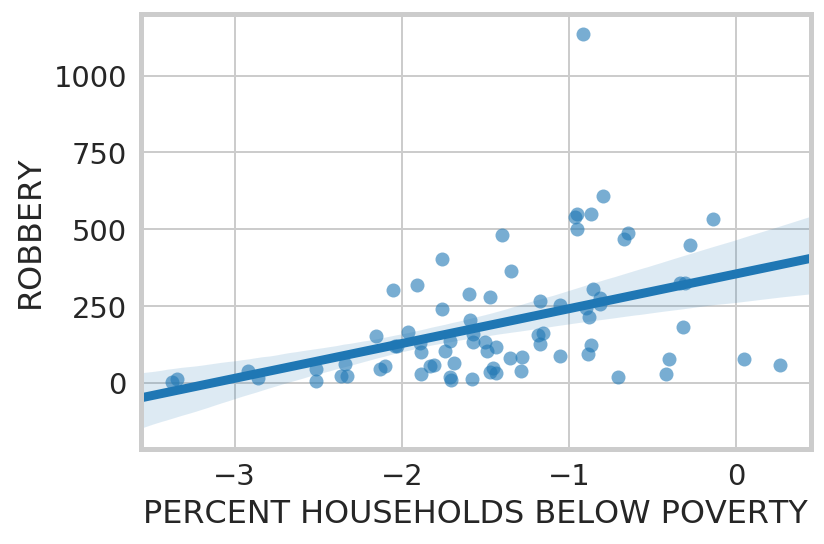

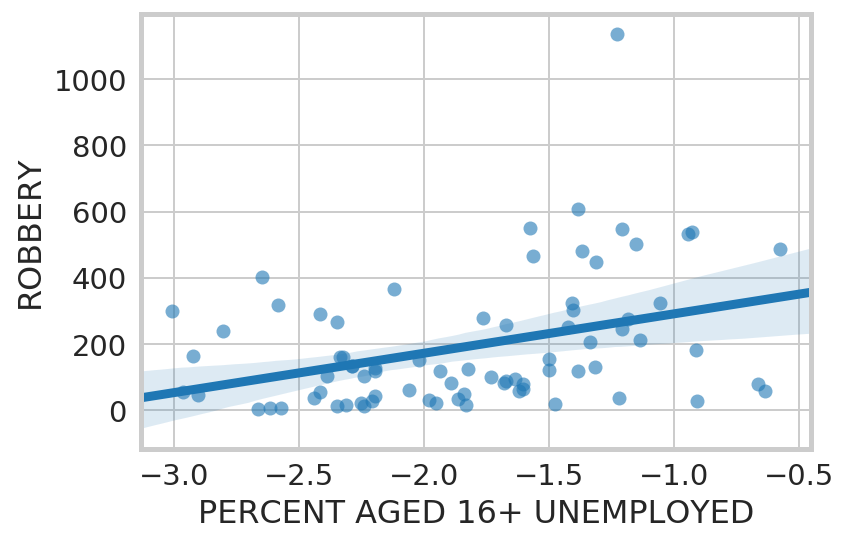

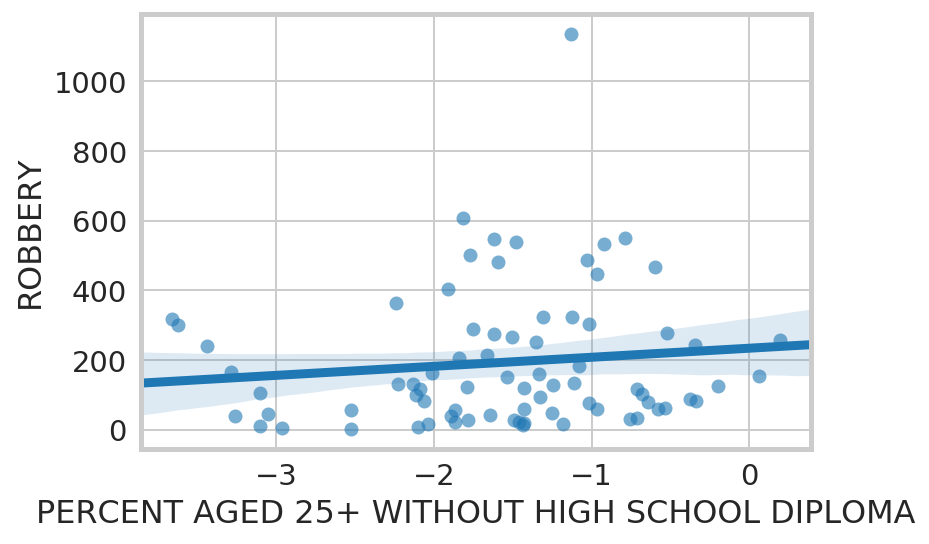

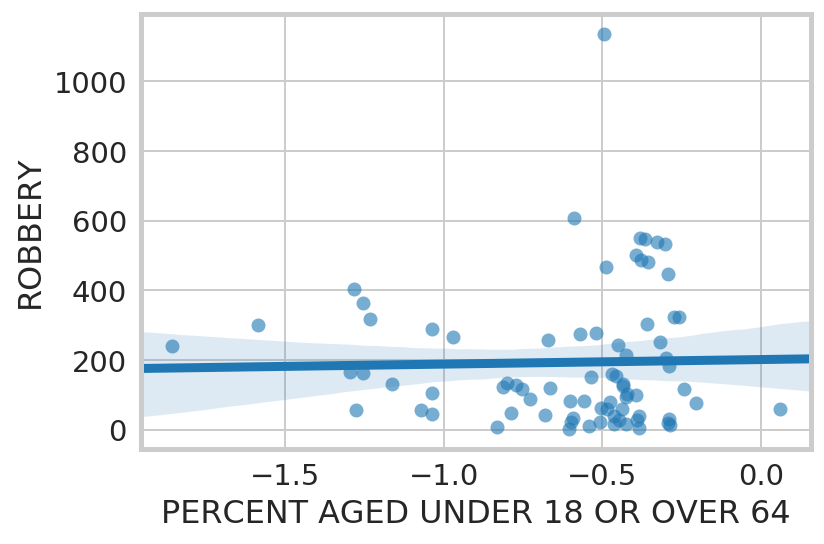

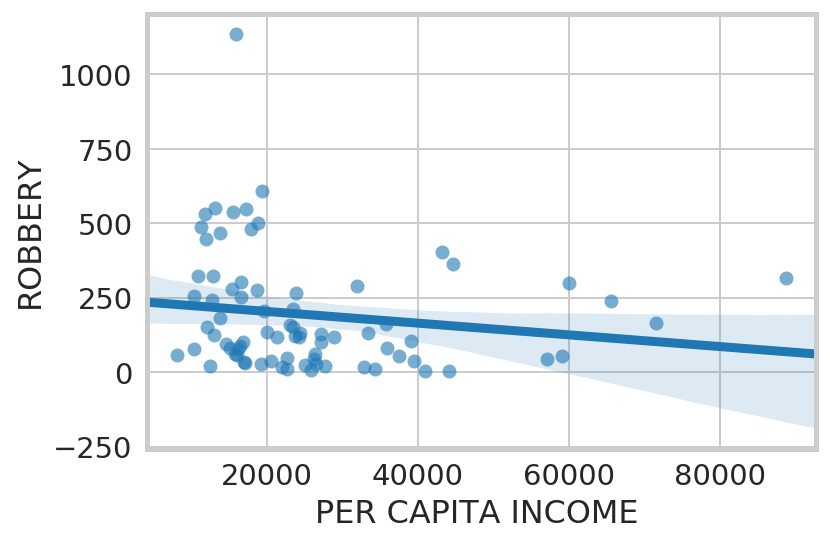

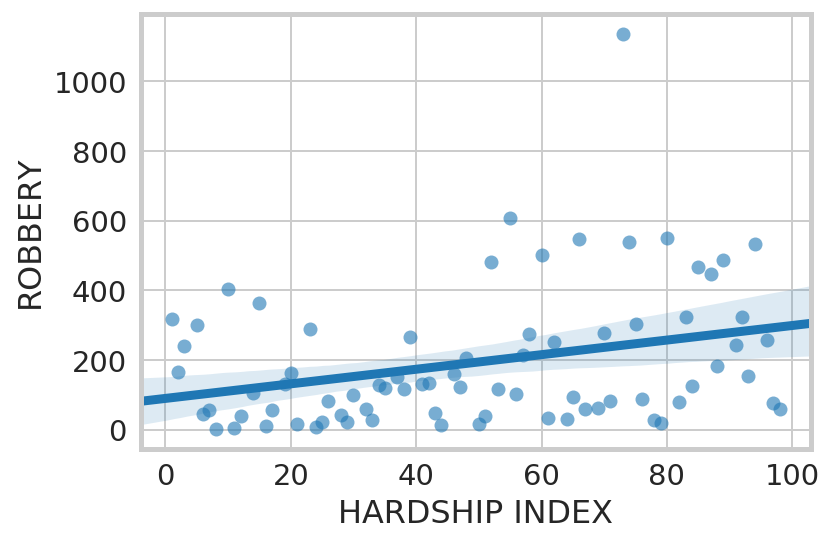

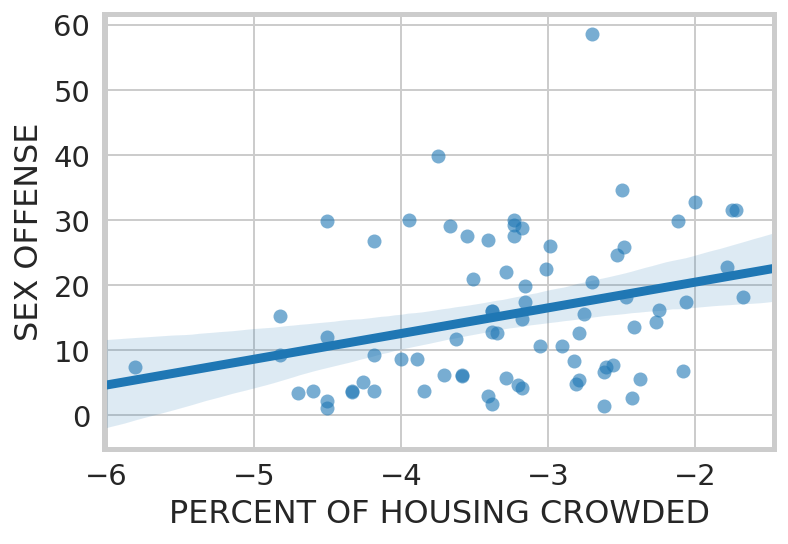

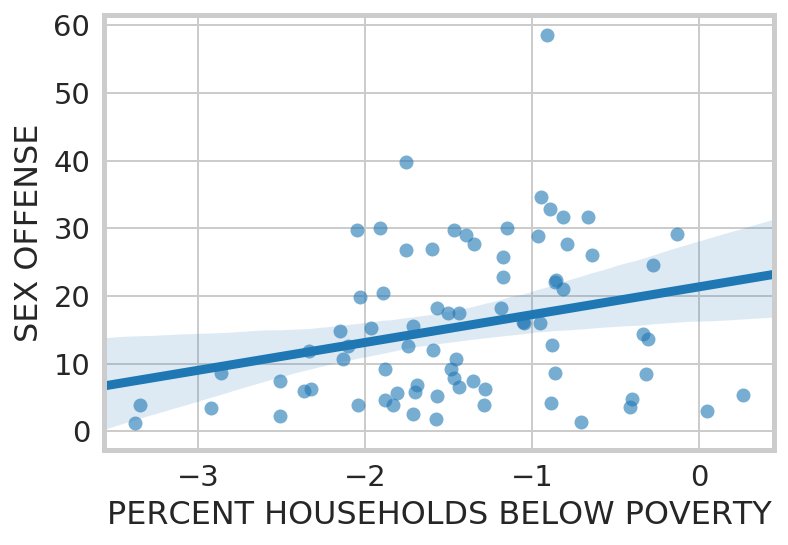

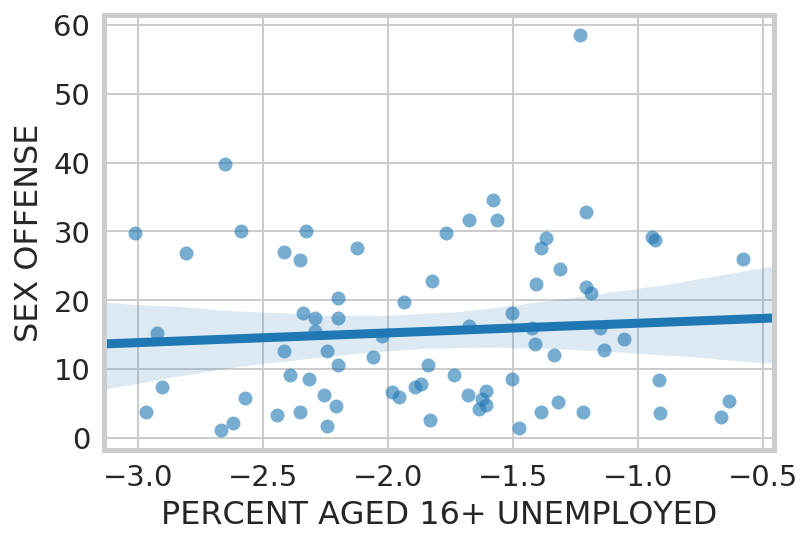

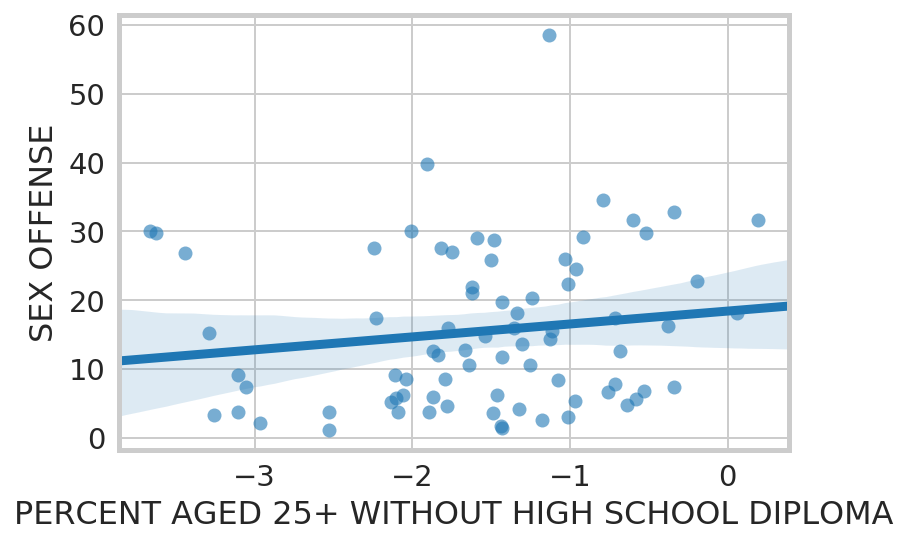

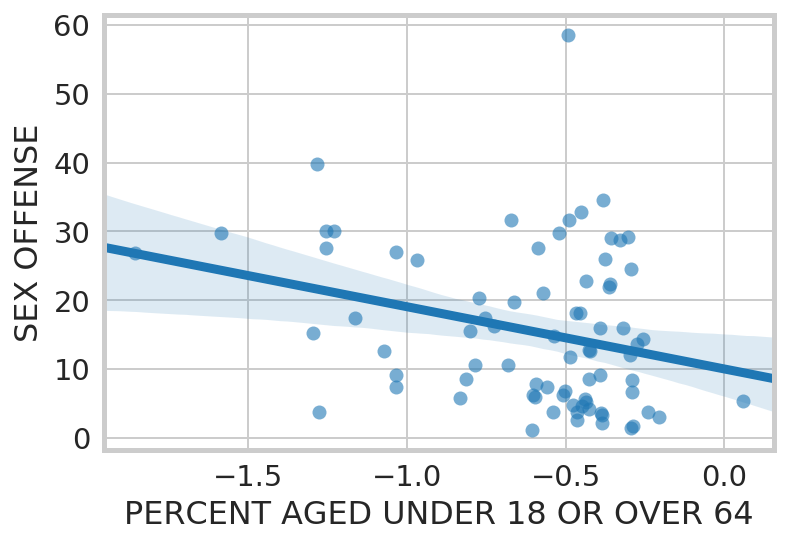

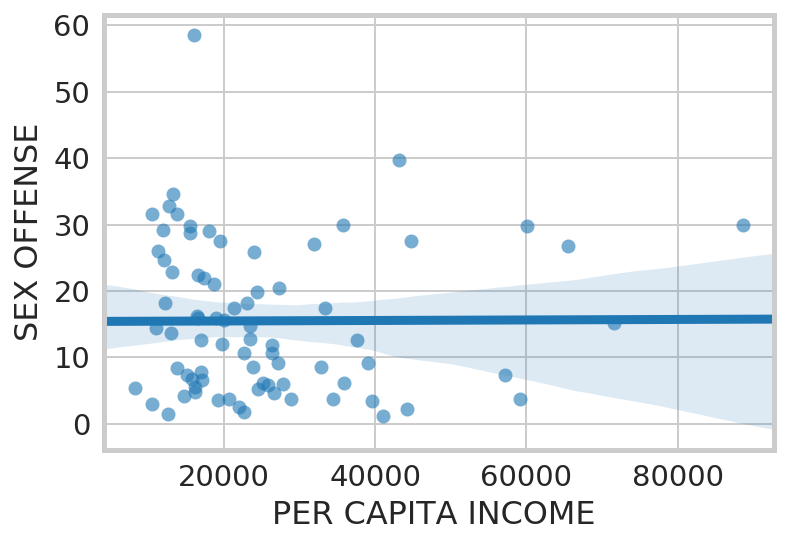

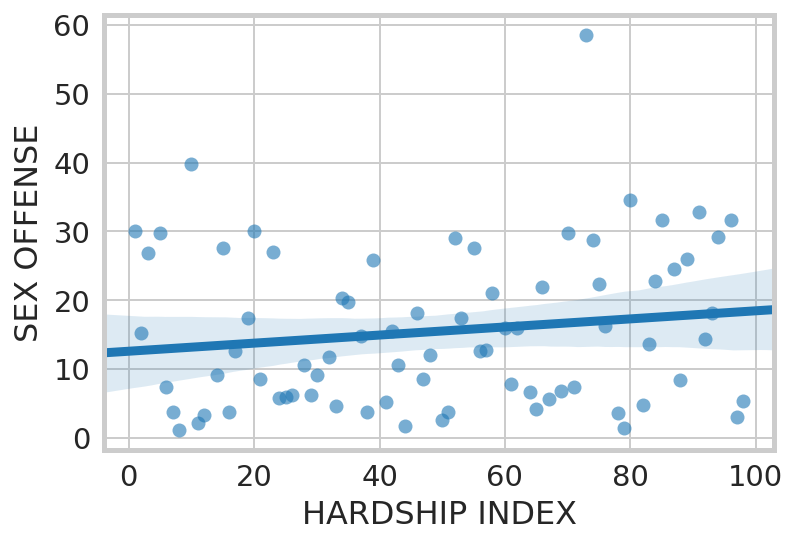

In [11]:
crimes_counter = 0
for crime in crimes_list:
    socio_counter = 0
    for socio in socio_list:
        crimes_df = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[crimes_counter])]
        ax = plt.figure()
        ax = sns.regplot(x = socio_list[socio_counter], y = 'No_Crimes', data = crimes_df, scatter_kws = {"alpha" : 0.6})
        ax.set_ylabel(crimes_list[crimes_counter])
#         ax.figure.savefig('output/primary_type/{}_{}.png'.format(socio_list[socio_counter], crimes_list[crimes_counter]), bbox_inches='tight', pad_inches=0.2)
        socio_counter += 1
    
    crimes_counter += 1

Plots showed some tendency, but not enough for statistical analysis. We need the summaries for multiple regression analysis.

In [12]:
# define a function for masking dataframes by Primary_Type

def crime_df(v):
    x = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[v])]
    return x

In [13]:
# use for loop to print out the summaries for each Primary_Type

for v in range(7):
    print(crimes_list[v])
    crime_type = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age + Income",
                  data = crime_df(v).rename(columns = {"No_Crimes"                                 : "Crime", 
                                                     "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                     "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                     "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                     "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                     "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                     "PER CAPITA INCOME "                         : "Income",}))
    entry = crime_type.fit()
    print(entry.summary())
    print()
    print()
    print()

HOMICIDE
                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     7.113
Date:                Mon, 04 Dec 2017   Prob (F-statistic):           6.58e-06
Time:                        13:27:03   Log-Likelihood:                -235.70
No. Observations:                  75   AIC:                             485.4
Df Residuals:                      68   BIC:                             501.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.6777      4.606      5.575

In [14]:
socio_list = ['PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX']

crimes_list = ['HOMICIDE', 'WEAPONS VIOLATION', 'THEFT', 'KIDNAPPING', 'NARCOTICS', 'ROBBERY', 'SEX OFFENSE']

#### According to the summaries generated above, these following relationships are significant at 0.1 level. 

Homicide - Crowd, Unemp;
Weapons Violation - Unemp;
Theft - Crowd, Unemp, Age, Income;
Kidnapping - Unemp;
Narcotics - Crowd, Unemp;
Robbery - Crowd, Unemp, Age;
Sex Offense - Crowd, Unemp, Age.

The coding for lowess plot is rather complicate. Therefore a lowess function is defined for plotting

In [15]:
def lowess(socio, crimes):

    ols = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age +Income",
                  data = crime_df(crimes).rename(columns = {"No_Crimes"                                 : "Crime", 
                                                     "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                     "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                     "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                     "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                     "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                     "PER CAPITA INCOME "                         : "Income",}))
    model = ols.fit()

    Se = pd.Series(name = "Component + Residual", data = model.resid + crime_df(crimes)[socio_list[socio]] * model.
                    params["Unemp"])
    ax = sns.regplot(x = crime_df(crimes)[socio_list[socio]], y = Se, scatter = True, fit_reg = False,
                scatter_kws = {"alpha" : 0.3, "color" : "grey"})
    sns.regplot(x = crime_df(crimes)[socio_list[socio]], y = Se, scatter = False, 
                lowess = False, robust = True, label = "Linear",
                scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
    sns.regplot(x = crime_df(crimes)[socio_list[socio]], y = Se, scatter = False, 
                lowess = True, label = "Lowess",
                scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);
    ax.set_ylabel(crimes_list[crimes])
    ax.legend() 
#     ax.figure.savefig("output/primary_type/lowess/lowess_{}_{}.png".format(socio_list[socio], crimes_list[crimes]),  bbox_inches='tight', pad_inches=0.2)

Then we plot all the significant relationships mentioned above one by one. The function ran multiple times,
but only one instance is shown below for layout reasons

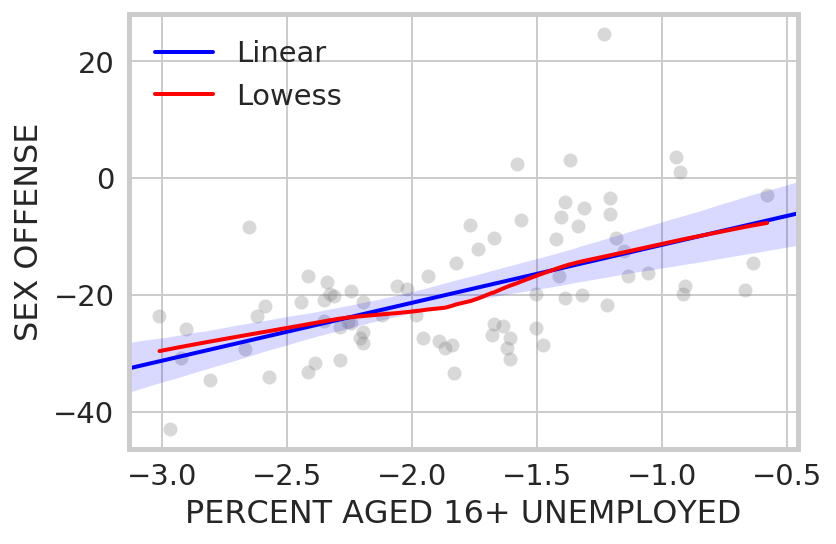

In [16]:
lowess(2, 6)

### We thought better of what we initially developed.
so here I list them in blocks for any reference purposes. 

In [62]:
# crime_type["Primary_Type"].unique()

In [22]:
# homicide = mix_type_logit.loc[(mix_type_logit['Primary_Type'] =='HOMICIDE')]  
# crimes_df = mix_type_logit.loc[(mix_type_logit['Primary_Type'] == crimes_list[counter])]
# # ax = plt.figure()
# crimes_df
# # homicide
# # ax = sns.regplot(x = socio_list[counter], y = 'No_Crimes', data = crimes_df, scatter_kws = {"alpha" : 0.6})

In [27]:
# weapons = mix_type_logit.loc[(mix_type_logit['Primary_Type'] =='WEAPONS VIOLATION')]  
# ax = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = weapons, scatter_kws = {"alpha" : 0.6});
# ax.set_ylabel('Weapons Violation')
# # weapons_hardship_plot.figure.savefig("output/weapons_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [28]:
# homicide = mix_type_logit.loc[(mix_type['Primary_Type'] =='HOMICIDE')]  
# homicide_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = homicide, scatter_kws = {"alpha" : 0.6});
# homicide_hardship_plot.set_ylabel('Homicide')
# homicide_hardship_plot.figure.savefig("output/homicide_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [26]:
# theft = mix_type_logit.loc[(mix_type['Primary_Type'] == 'THEFT')] 
# theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
# theft_hardship_plot.set_ylabel('Theft')
# theft_hardship_plot.figure.savefig("output/theft_hardship.png",  bbox_inches='tight', pad_inches=0.2)

In [19]:
# theft = mix_type.loc[(mix_type['Primary_Type'] == 'THEFT') | (mix_type['Primary_Type'] == 'MOTOR VEHICLE THEFT')] 
# theft_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = theft, scatter_kws = {"alpha" : 0.6});
# theft_hardship_plot.set_ylabel('Theft')
# # theft_hardship_plot.figure.savefig("theft_hardship.png")

In [20]:
# narcotics = mix_type_logit.loc[(mix_type['Primary_Type'] == 'NARCOTICS')]  
# narcotics_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = narcotics, scatter_kws = {"alpha" : 0.6});
# narcotics_hardship_plot.set_ylabel('Narcotics')
# narcotics_hardship_plot.figure.savefig("output/narcotics_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [21]:
# kidnap = mix_type_logit.loc[(mix_type['Primary_Type'] == 'KIDNAPPING')]  
# kidnap_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = kidnap, scatter_kws = {"alpha" : 0.6});
# kidnap_hardship_plot.set_ylabel('Kidnap')
# kidnap_hardship_plot.figure.savefig("output/kidnap_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [22]:
# robbery = mix_type_logit.loc[(mix_type['Primary_Type'] == 'ROBBERY')]  
# robbery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = robbery, scatter_kws = {"alpha" : 0.6});
# robbery_hardship_plot.set_ylabel('Robbery')
# robbery_hardship_plot.figure.savefig("output/robbery_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [23]:
# battery = mix_type_logit.loc[(mix_type['Primary_Type'] == 'BATTERY')]  
# battery_hardship_plot = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = battery, scatter_kws = {"alpha" : 0.6}); 
# battery_hardship_plot.set_ylabel('Battery')
# battery_hardship_plot.figure.savefig("output/battery_hardship.png", bbox_inches='tight', pad_inches=0.2)

In [23]:
# ols_homicide = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age +Income",
#               data = homicide.rename(columns = {"No_Crimes"                                 : "Crime", 
#                                                  "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
#                                                  "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
#                                                  "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
#                                                  "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
#                                                  "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
#                                                  "PER CAPITA INCOME "                         : "Income",}))
# model_homicide = ols_homicide.fit()
# # model_homicide.summary() 

In [ ]:
# # we can see that unemp and crwod are significant at 0.1 level 
# ols_homicide = smf.ols(formula = "Crime ~ Crowd + Unemp",
#               data = homicide.rename(columns = {"No_Crimes"                                 : "Crime", 
#                                                  "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
#                                                  "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
#                                                  "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
#                                                  "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
#                                                  "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
#                                                  "PER CAPITA INCOME "                         : "Income",}))
# model_homicide = ols_homicide.fit()
# model_homicide.summary() 